The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.16.5
!pip install -U mxnet-cu101==1.7.0


# Dog Breed Identification (ImageNet Dogs) on Kaggle

In this section, we will practice
the dog breed identification problem on
Kaggle. The web address of this competition is https://www.kaggle.com/c/dog-breed-identification

In this competition,
120 different breeds of dogs will be recognized.
In fact,
the dataset for this competition is
a subset of the ImageNet dataset.
Unlike the images in the CIFAR-10 dataset in :numref:`sec_kaggle_cifar10`, 
the images in the ImageNet dataset are both higher and wider in varying dimensions.
:numref:`fig_kaggle_dog` shows the information on the competition's webpage. You need a Kaggle account
to submit your results.


![The dog breed identification competition website. The competition dataset can be obtained by clicking the "Data" tab.](../img/kaggle-dog.jpg)
:width:`400px`
:label:`fig_kaggle_dog`


In [1]:
import os
from mxnet import autograd, gluon, init, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## Obtaining and Organizing the Dataset

The competition dataset is divided into a training set and a test set, which contain 10222 and 10357 JPEG images
of three RGB (color) channels, respectively.
Among the training dataset,
there are 120 breeds of dogs
such as Labradors, Poodles, Dachshunds, Samoyeds, Huskies, Chihuahuas, and Yorkshire Terriers.


### Downloading the Dataset

After logging into Kaggle,
you can click on the "Data" tab on the 
competition webpage shown in :numref:`fig_kaggle_dog` and download the dataset by clicking the "Download All" button. 
After unzipping the downloaded file in `../data`, you will find the entire dataset in the following paths:

* ../data/dog-breed-identification/labels.csv
* ../data/dog-breed-identification/sample_submission.csv
* ../data/dog-breed-identification/train
* ../data/dog-breed-identification/test

You may have noticed that the above structure is
similar to that of the CIFAR-10 competition in :numref:`sec_kaggle_cifar10`, where folders `train/` and `test/` contain training and testing dog images, respectively, and `labels.csv` contains
the labels for the training images.
Similarly, to make it easier to get started, we provide a small sample of the dataset mentioned above: `train_valid_test_tiny.zip`.
If you are going to use the full dataset for the Kaggle competition, you need to change the `demo` variable below to `False`.


In [2]:
#@save
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

# If you use the full dataset downloaded for the Kaggle competition, change
# the variable below to `False`
demo = True
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

### Organizing the Dataset

We can organize the dataset similarly to what we did in :numref:`sec_kaggle_cifar10`, namely splitting out
a validation set from the original training set, and moving images into subfolders grouped by labels.

The `reorg_dog_data` function below reads
the training data labels, splits out the validation set, and organizes the training set.


In [3]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)

batch_size = 4 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

## Image Augmentation

Recall that this dog breed dataset
is a subset of the ImageNet dataset,
whose images
are larger than those of the CIFAR-10 dataset
in :numref:`sec_kaggle_cifar10`.
The following 
lists a few image augmentation operations
that might be useful for relatively larger images.


In [4]:
transform_train = gluon.data.vision.transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height-to-width ratio between 3/4 and 4/3. Then,
    # scale the image to create a new 224 x 224 image
    gluon.data.vision.transforms.RandomResizedCrop(
        224, scale=(0.08, 1.0), ratio=(3.0 / 4.0, 4.0 / 3.0)),
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    # Randomly change the brightness, contrast, and saturation
    gluon.data.vision.transforms.RandomColorJitter(brightness=0.4,
                                                   contrast=0.4,
                                                   saturation=0.4),
    # Add random noise
    gluon.data.vision.transforms.RandomLighting(0.1),
    gluon.data.vision.transforms.ToTensor(),
    # Standardize each channel of the image
    gluon.data.vision.transforms.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])])

During prediction,
we only use image preprocessing operations
without randomness.


In [5]:
transform_test = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize(256),
    # Crop a 224 x 224 square area from the center of the image
    gluon.data.vision.transforms.CenterCrop(224),
    gluon.data.vision.transforms.ToTensor(),
    gluon.data.vision.transforms.Normalize([0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])])

## Reading the Dataset

As in :numref:`sec_kaggle_cifar10`,
we can read the organized dataset
consisting of raw image files.


In [6]:
train_ds, valid_ds, train_valid_ds, test_ds = [
    gluon.data.vision.ImageFolderDataset(
        os.path.join(data_dir, 'train_valid_test', folder))
    for folder in ('train', 'valid', 'train_valid', 'test')]

Below we create data loader instances
the same way
as in :numref:`sec_kaggle_cifar10`.


In [7]:
train_iter, train_valid_iter = [
    gluon.data.DataLoader(dataset.transform_first(transform_train),
                          batch_size, shuffle=True, last_batch='discard')
    for dataset in (train_ds, train_valid_ds)]

valid_iter = gluon.data.DataLoader(valid_ds.transform_first(transform_test),
                                   batch_size, shuffle=False,
                                   last_batch='discard')

test_iter = gluon.data.DataLoader(test_ds.transform_first(transform_test),
                                  batch_size, shuffle=False,
                                  last_batch='keep')

## Fine-Tuning a Pretrained Model

Again,
the dataset for this competition is a subset of the ImageNet dataset. 
Therefore, we can use the approach discussed in
:numref:`sec_fine_tuning`
to select a model pretrained on the
full ImageNet dataset and use it to extract image features to be fed into a
custom small-scale output network. 
High-level APIs of deep learning frameworks
provide a wide range of models
pretrained on the ImageNet dataset.
Here, we choose
a pretrained ResNet-34 model,
where we simply reuse
the input of this model's output layer
(i.e., the extracted
features).
Then we can replace the original output layer with a small custom
output network that can be trained,
such as stacking two
fully-connected layers.
Different from the experiment in
:numref:`sec_fine_tuning`, 
the following does 
not retrain the pretrained model used for feature
extraction. This reduces training time and
memory for storing gradients.

Recall that we
standardized images using
the means and standard deviations of the three RGB channels for the full ImageNet dataset.
In fact, 
this is also consistent with the standardization operation
by the pretrained model on ImageNet.


In [8]:
def get_net(devices):
    finetune_net = gluon.model_zoo.vision.resnet34_v2(pretrained=True)
    # Define a new output network
    finetune_net.output_new = nn.HybridSequential(prefix='')
    finetune_net.output_new.add(nn.Dense(256, activation='relu'))
    # There are 120 output categories
    finetune_net.output_new.add(nn.Dense(120))
    # Initialize the output network
    finetune_net.output_new.initialize(init.Xavier(), ctx=devices)
    # Distribute the model parameters to the CPUs or GPUs used for computation
    finetune_net.collect_params().reset_ctx(devices)
    return finetune_net

Before calculating the loss,
we first obtain the input of the pretrained model's output layer, i.e., the extracted feature.
Then we use this feature as the input for our small custom output network to calculate the loss.


In [9]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        X_shards, y_shards = d2l.split_batch(features, labels, devices)
        output_features = [net.features(X_shard) for X_shard in X_shards]
        outputs = [net.output_new(feature) for feature in output_features]
        ls = [
            loss(output, y_shard).sum()
            for output, y_shard in zip(outputs, y_shards)]
        l_sum += sum([float(l.sum()) for l in ls])
        n += labels.size
    return l_sum / n

## Defining the Training Function

We will select the model and tune hyperparameters according to the model's performance on the validation set. The model training function `train` only
iterates parameters of the small custom output network.


In [10]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # Only train the small custom output network
    trainer = gluon.Trainer(net.output_new.collect_params(), 'sgd', {
        'learning_rate': lr,
        'momentum': 0.9,
        'wd': wd})
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'valid loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            X_shards, y_shards = d2l.split_batch(features, labels, devices)
            output_features = [net.features(X_shard) for X_shard in X_shards]
            with autograd.record():
                outputs = [
                    net.output_new(feature) for feature in output_features]
                ls = [
                    loss(output, y_shard).sum()
                    for output, y_shard in zip(outputs, y_shards)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            metric.add(sum([float(l.sum()) for l in ls]), labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss))
    if valid_iter is not None:
        print(f'train loss {metric[0] / metric[1]:.3f}, '
              f'valid loss {valid_loss:.3f}')
    else:
        print(f'train loss {metric[0] / metric[1]:.3f}')
    print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

## Training and Validating the Model

Now we can train and validate the model.
The following hyperparameters are all tunable.
For example, the number of epochs can be increased. Because `lr_period` and `lr_decay` are set to 10 and 0.1, respectively, the learning rate of the optimization algorithm will be multiplied by 0.1 after every 10 epochs.


train loss 2.245, valid loss 2.271
218.6 examples/sec on [gpu(0), gpu(1)]


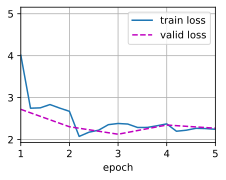

In [11]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 5, 0.01, 1e-4
lr_period, lr_decay, net = 10, 0.1, get_net(devices)
net.hybridize()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

## Classifying the Testing Set and Submitting Results on Kaggle


Similar to the final step in :numref:`sec_kaggle_cifar10`,
in the end all the labeled data (including the validation set) are used for training the model and classifying the testing set.
We will use the trained custom output network
for classification.


train loss 2.313
219.3 examples/sec on [gpu(0), gpu(1)]


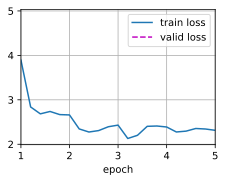

In [12]:
net = get_net(devices)
net.hybridize()
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    output_features = net.features(data.as_in_ctx(devices[0]))
    output = npx.softmax(net.output_new(output_features))
    preds.extend(output.asnumpy())
ids = sorted(
    os.listdir(os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.synsets) + '\n')
    for i, output in zip(ids, preds):
        f.write(
            i.split('.')[0] + ',' + ','.join([str(num)
                                              for num in output]) + '\n')

The above code
will generate a `submission.csv` file
to be submitted 
to Kaggle in the same way described in :numref:`sec_kaggle_house`.


## Summary


* Images in the ImageNet dataset are larger (with varying dimensions) than CIFAR-10 images. We may modify image augmentation operations for tasks on a different dataset. 
* To classify a subset of the ImageNet dataset, we can leverage pre-trained models on the full ImageNet dataset to extract features and only train a custom small-scale output network. This will lead to less computational time and memory cost.


## Exercises

1. When using the fill Kaggle competition dataset, what results can you achieve when you increase the `batch_size` (batch size) and `num_epochs` (number of epochs)?
1. Do you get better results if you use a deeper pretrained model? How do you tune hyperparameters? Can you further improve the results?


[Discussions](https://discuss.d2l.ai/t/380)
